In [1]:
import os
import sys
import pdb
import time
import glob
import functools
import multiprocessing
import numpy as np
import soundfile as sf
import scipy.interpolate
import scipy.io
import scipy.signal
import h5py
import tqdm
import soxr
import importlib

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches
import IPython.display as ipd

sys.path.append('/om2/user/msaddler/python-packages/msutil')
import util_figures
import util_stimuli
import util_misc

import simulator
importlib.reload(simulator)


<module 'simulator' from '/rdma/vast-rdma/vast/mcdermott/msaddler/python-packages/virtual_acoustic_room/simulator.py'>

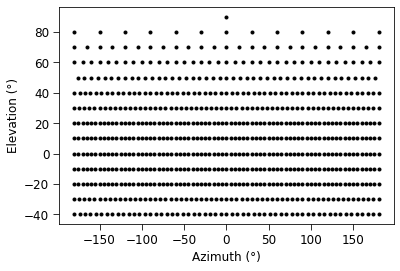

In [33]:
hrtf_locs, hrtf_firs, hrtf_sr = simulator.load_kemar_hrtfs(npz_filename='kemar_hrtfs/hrtfs.npz')

IDX_nonzero_azim = hrtf_locs[:, 1] != 0
opposite_hrtf_locs = hrtf_locs[IDX_nonzero_azim, :]
opposite_hrtf_locs[:, 1] = -1 * opposite_hrtf_locs[:, 1] # Multiply azimuth by negative one
opposite_hrtf_firs = np.flip(hrtf_firs[IDX_nonzero_azim, :, :], axis=2) # Switch left/right channel
hrtf_locs = np.concatenate([opposite_hrtf_locs, hrtf_locs], axis=0)
hrtf_firs = np.concatenate([opposite_hrtf_firs, hrtf_firs], axis=0)
hrtf_locs.shape, hrtf_firs.shape

"""
Check kemar_hrtf locations (azimuths and elevations)
"""
fig, ax = plt.subplots()
x = hrtf_locs[:, 1]
y = hrtf_locs[:, 2]
ax.plot(x, y, 'k.')
ax = util_figures.format_axes(
    ax,
    str_xlabel='Azimuth (°)',
    str_ylabel='Elevation (°)')
plt.show()


In [2]:
"""
Run this cell to start the MATLAB engine for Python and import `simulator_matlab`
"""
import matlab.engine
import simulator_matlab
importlib.reload(simulator_matlab)

eng = matlab.engine.start_matlab();
if 'src/' not in eng.path():
    eng.addpath('src/');


In [ ]:
"""
Quit MATLAB engine
"""
eng.quit()


In [79]:
"""
DEBUGGING: CLOSELY COMPARE MATLAB AND PYTHON SIMULATORS UNDER DIFFERENT CONDITIONS

NOTES:
- Resulting BRIRs are sometimes offset by one or two samples
    - May be due to an off-by-one indexing error when porting MATLAB to Python
    - May be due to numerical precision differences
"""
room_materials = [26]*6#[1, 1, 1, 1, 15, 16]
room_dim_xyz = [7, 8, 4]
head_pos_xyz = [3.6, 1.4, 2.0]
head_azim = -49
src_azim = 145
src_elev = 20
src_dist = 3.4
buffer = 0.5

c = 344.5
buffer = 0
sr = 44100
dur = 0.5
use_hrtf_symmetry = True
use_highpass = True
use_jitter = False
incorporate_lead_zeros = True
use_log_distance = True
hrtf_locs = None
hrtf_firs = None

importlib.reload(simulator)

np.random.seed(0)
brir_python = simulator.get_brir(
    room_materials=room_materials,
    room_dim_xyz=room_dim_xyz,
    head_pos_xyz=head_pos_xyz,
    head_azim=head_azim,
    src_azim=src_azim,
    src_elev=src_elev,
    src_dist=src_dist,
    buffer=buffer,
    sr=sr,
    c=c,
    dur=dur,
    hrtf_locs=hrtf_locs,
    hrtf_firs=hrtf_firs,
    use_hrtf_symmetry=use_hrtf_symmetry,
    use_log_distance=use_log_distance,
    use_jitter=use_jitter,
    use_highpass=use_highpass,
    incorporate_lead_zeros=incorporate_lead_zeros,
    processes=8,
    strict=True,
    verbose=2)


[get_brir] loaded kemar_hrtfs (Gardner & Martin, 1994): (368, 128, 2)
[get_brir] head_pos: [3.6, 1.4, 2.0], src_pos: [3.2660362729780035, 4.577452613377778, 3.1628684873072737], room_dim: [7, 8, 4]
... processing 235 unique source locations
... processing 261 unique source locations
... processing 289 unique source locations
... processing 299 unique source locations
... processing 311 unique source locations
... processing 320 unique source locations
... processing 345 unique source locations
... processing 339 unique source locations
... processing 239 unique source locations
[get_brir] time elapsed: 7.595329523086548 seconds
[get_brir] incorporated 256 leading zeros


In [80]:
importlib.reload(simulator_matlab)

np.random.seed(0)
brir_matlab = simulator_matlab.get_brir(
    room_materials=room_materials,
    room_dim_xyz=room_dim_xyz,
    head_pos_xyz=head_pos_xyz,
    head_azim=head_azim,
    src_azim=src_azim,
    src_elev=src_elev,
    src_dist=src_dist,
    buffer=buffer,
    sr=sr,
    c=c,
    dur=dur,
    use_hrtf_symmetry=use_hrtf_symmetry,
    use_log_distance=use_log_distance,
    use_jitter=use_jitter,
    use_highpass=use_highpass,
    incorporate_lead_zeros=incorporate_lead_zeros,
    eng=eng)


[get_brir] head_pos: [3.6, 1.4, 2.0], src_pos: [3.2660362729780035, 4.577452613377778, 3.1628684873072737], room_dim: [7, 8, 4]
[get_brir] time elapsed: 7.910022258758545 seconds
[get_brir] incorporated 256 leading zeros


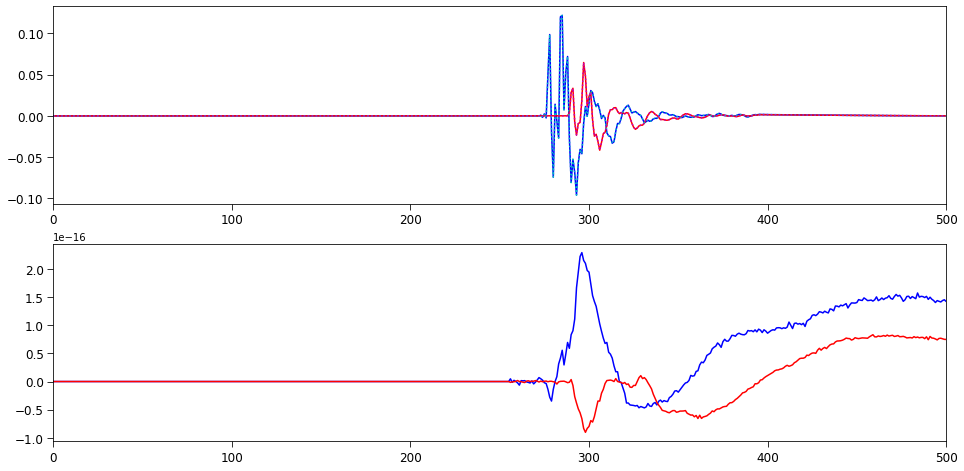

In [82]:
fig, ax_arr = plt.subplots(figsize=(16, 8), nrows=2, ncols=1)

offset_brir_python = brir_python[1:]
offset_brir_matlab = brir_matlab[:-1]

ax_arr[0].plot(offset_brir_python[:, 0], 'b')
ax_arr[0].plot(offset_brir_python[:, 1], 'r')
ax_arr[0].plot(offset_brir_matlab[:, 0], 'c', ls=':')
ax_arr[0].plot(offset_brir_matlab[:, 1], 'm', ls=':')
ax_arr[1].plot(offset_brir_python[:, 0] - offset_brir_matlab[:, 0], 'b')
ax_arr[1].plot(offset_brir_python[:, 1] - offset_brir_matlab[:, 1], 'r')

for ax in ax_arr:
    util_figures.format_axes(
        ax,
        xlimits=[0, 500],
#         ylimits=[-0.01, 0.01]
    )
plt.show()


In [3]:
importlib.reload(simulator);

for _ in range(300):
    np.random.seed(_)
    room_parameters = simulator.sample_room_parameters(verbose=False)
    head_parameters = simulator.sample_head_parameters(room_dim_xyz=room_parameters['room_dim_xyz'], verbose=False)
    room_dim_xyz = room_parameters['room_dim_xyz']
    head_azim = head_parameters['head_azim']
    head_azim = 0
    head_pos_xyz = head_parameters['head_pos_xyz']
    buffer_pos = 0
    for src_azim in range(0, 360, 15):
        for src_elev in range(-60, 61, 5):
            src_dist = simulator.distance_to_wall(
                room_dim_xyz,
                head_pos_xyz,
                head_azim,
                src_azim,
                src_elev)
            src_pos_xyz = np.array([
                src_dist * np.cos(np.deg2rad(src_elev)) * np.cos(np.deg2rad(src_azim + head_azim)) + head_pos_xyz[0],
                src_dist * np.cos(np.deg2rad(src_elev)) * np.sin(np.deg2rad(src_azim + head_azim)) + head_pos_xyz[1],
                src_dist * np.sin(np.deg2rad(src_elev)) + head_pos_xyz[2],
            ])
            assert simulator.is_valid_position(head_pos_xyz, room_dim_xyz, buffer=buffer_pos), "Invalid head position"
            if (np.sum(np.isclose(src_pos_xyz, 0)) == 1) or (np.sum(np.isclose(src_pos_xyz, room_dim_xyz)) == 1):
                pass
            else:
                print(src_azim, src_elev, room_dim_xyz, src_pos_xyz)


/rdma/vast-rdma/vast/mcdermott/msaddler/python-packages/virtual_acoustic_room/simulator.py:910: RuntimeWarning: divide by zero encountered in double_scalars
  ry = (room_dim_xyz[1] - head_pos_xyz[1]) / (np.sin(np.deg2rad(azim)) * np.cos(np.deg2rad(elev)))


30 30 [9.181887107492445, 20.147813552314354, 5.8145156138141845] [9.18183278 6.11399071 5.81451561]


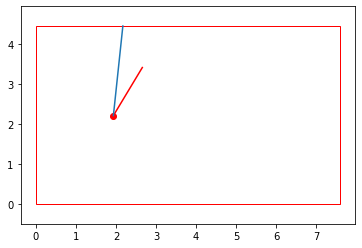

Checked src_azim: 25 = 25.000000000000004


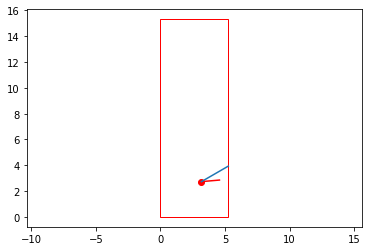

Checked src_azim: 25 = 25.000000000000004


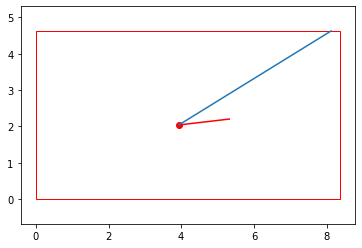

Checked src_azim: 25 = 24.99999999999999


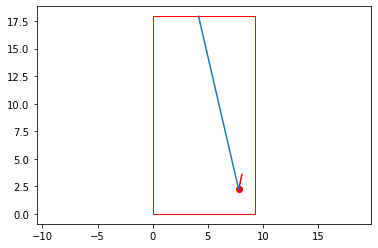

Checked src_azim: 25 = 24.99999999999999


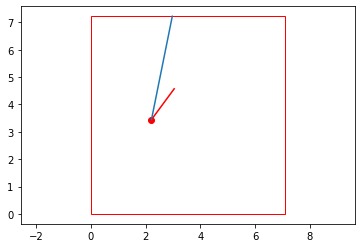

Checked src_azim: 25 = 24.999999999999975


In [4]:
for _ in range(5):
    room_parameters = simulator.sample_room_parameters(verbose=False)
    head_parameters = simulator.sample_head_parameters(room_dim_xyz=room_parameters['room_dim_xyz'], verbose=False)
    room_dim_xyz = room_parameters['room_dim_xyz']
    head_azim = head_parameters['head_azim']
    head_pos_xyz = head_parameters['head_pos_xyz']
    
    fig, ax = plt.subplots()
    rect = matplotlib.patches.Rectangle((0, 0), room_dim_xyz[0], room_dim_xyz[1], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.plot(head_pos_xyz[0], head_pos_xyz[1], 'ro')
    src_azim = 25
    src_elev = 5
    src_dist = simulator.distance_to_wall(
        room_dim_xyz,
        head_pos_xyz,
        head_azim=head_azim,
        src_azim=src_azim,
        src_elev=src_elev)
    dhx = 1.4 * np.cos(np.deg2rad(head_azim))
    dhy = 1.4 * np.sin(np.deg2rad(head_azim))
    dx = src_dist * np.cos(np.deg2rad(head_azim + src_azim)) * np.cos(np.deg2rad(src_elev))
    dy = src_dist * np.sin(np.deg2rad(head_azim + src_azim)) * np.cos(np.deg2rad(src_elev))
    ax.plot([head_pos_xyz[0], head_pos_xyz[0] + dhx], [head_pos_xyz[1], head_pos_xyz[1] + dhy], 'r-')
    ax.plot([head_pos_xyz[0], head_pos_xyz[0] + dx], [head_pos_xyz[1], head_pos_xyz[1] + dy])
    ax.set_aspect('equal', 'datalim')
    plt.show()
    
    vector1 = np.array([dx, dy])
    vector2 = np.array([dhx, dhy])
    unit_vector1 = vector1 / np.linalg.norm(vector1)
    unit_vector2 = vector2 / np.linalg.norm(vector2)
    dot_product = np.dot(unit_vector1, unit_vector2)
    angle = np.rad2deg(np.arccos(dot_product))
    print(f'Checked src_azim: {src_azim} = {angle}')
